# RQ1 — Evaluating Household Tariffs on ResStock MA Sample

**Research Question 1 (RQ1)**  
How do different retail electricity tariff structures (e.g., flat rate, time-of-use, real-time pricing proxy) affect:
- total annual bills for households, and  
- the distribution of costs across households with different characteristics  
in a realistic sample of Massachusetts residential load profiles?

This notebook:
1. Loads a sample of individual-building 15-minute load profiles from the NREL ResStock AMY2018 dataset (MA, upgrade 0 / baseline).  
2. Loads the corresponding building-level metadata and dictionary files.  
3. Runs sanity checks to confirm we have the right data to evaluate RQ1 before scaling to the full dataset.  

In [13]:
from pathlib import Path
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 4)

# Make sure we can import loadOEDIData.py from aidms-final-project
project_dir = Path("aidms-final-project").resolve()
if str(project_dir) not in sys.path:
    sys.path.append(str(project_dir))

from loadOEDIData import load_all, load_timeseries_for_buildings

print("Python executable:", sys.executable)
print("Project dir:", project_dir)


Python executable: c:\Users\Manny\AppData\Local\Programs\Python\Python312\python.exe
Project dir: C:\Users\Manny\Desktop\aidms\aidms-final-project\aidms-final-project


## Data sources and formats

We use a local mirror of the NREL **ResStock AMY2018** dataset:

- **Source:** `oedi-data-lake/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2025/resstock_amy2018_release_1`
- **Local root:** `../OEDIDataset/`

Within `OEDIDataset`:

- `*.parquet` — Individual-building 15-minute timeseries for **baseline** (`upgrade_id = 0`) buildings in Massachusetts.  
  - Columns include `bldg_id`, `timestamp`, `in.sqft`, and multiple `out.electricity.*.energy_consumption..kwh` end-use columns.
- `metadata/upgrade0.parquet` — Building-level characteristics and annual results for all baseline buildings (nationwide).
- `dictionaries/`
  - `data_dictionary.tsv` — Descriptions of all `in.*` and `out.*` fields.
  - `enumeration_dictionary.tsv` — Expansion of categorical codes (e.g., region, tenure).
- `timeseries_aggregates/by_state/state=MA/*.csv` — MA-level aggregate load profiles by building type (used for sanity checks).

This notebook **only** touches whichever building timeseries files are present in `OEDIDataset` (e.g., the initial 1000 MA buildings, or more if added later).


In [2]:
# Load all preprocessed pieces via helper module
all_data = load_all()

meta = all_data["metadata"]                      # building-level metadata (nationwide)
data_dict = all_data["data_dictionary"]          # column descriptions
enum_dict = all_data["enumeration_dictionary"]   # enumeration descriptions
ts_index = all_data["timeseries_index"]          # index of local building timeseries files
agg_ma = all_data["state_aggregates"]            # MA state-level aggregates (if present)

print("Metadata shape:", None if meta is None else meta.shape)
print("Timeseries files (local):", len(ts_index))
print("Data dictionary:", None if data_dict is None else data_dict.shape)
print("Enumeration dictionary:", None if enum_dict is None else enum_dict.shape)
print("MA aggregates:", None if agg_ma is None else agg_ma.shape)

# Restrict metadata to the buildings we actually downloaded timeseries for
if meta is not None:
    bldg_ids = ts_index["building_id"].unique()
    meta_sample = meta[meta["bldg_id"].isin(bldg_ids)].copy()
    print("Metadata rows for local timeseries buildings:", len(meta_sample))
else:
    meta_sample = None


=== Loading OEDI dataset pieces ===
[load_metadata] Reading upgrade0.parquet ...
[load_metadata] Combined metadata shape: (549971, 771)
[load_dictionaries] Reading data_dictionary.tsv ...
[load_dictionaries] data_dictionary shape: (841, 5)
[load_dictionaries] Reading enumeration_dictionary.tsv ...
[load_dictionaries] UTF-8 decode failed, retrying with latin-1 ...
[load_dictionaries] enumeration_dictionary shape: (58457, 3)
[build_timeseries_index] Found timeseries files: 1000
[load_state_aggregates] Reading up00-ma-mobile_home.csv ...
[load_state_aggregates] Reading up00-ma-multi-family_with_2_-_4_units.csv ...
[load_state_aggregates] Reading up00-ma-multi-family_with_5plus_units.csv ...
[load_state_aggregates] Reading up00-ma-single-family_attached.csv ...
[load_state_aggregates] Reading up00-ma-single-family_detached.csv ...
[load_state_aggregates] Combined aggregate shape: (175200, 97)
=== Done loading OEDI dataset pieces ===
Metadata shape: (549971, 771)
Timeseries files (local): 1

## Sanity checks before using this sample for RQ1

Before designing tariffs and computing bills, we want to confirm:

1. **Timeseries coverage**  
   - Each building has full-year 15-minute data (no large gaps).  
   - We can compute total kWh per 15-min step by summing end-use columns.

2. **Metadata alignment**  
   - Every building with timeseries has a matching metadata row.  
   - We have key fairness-relevant attributes: income proxy, building type, tenure, region/county.

3. **Reasonable consumption levels**  
   - Annual kWh per building is in a plausible range.  
   - Aggregate behavior roughly matches MA state aggregates.

We’ll do lightweight checks using a subset of buildings (e.g., up to 50), but code is written to adapt to any number of local parquet files.


In [3]:
# Choose how many buildings to use for sanity checks
N_SAMPLE_BUILDINGS = 50

n_available = len(ts_index)
n_use = min(N_SAMPLE_BUILDINGS, n_available)
print(f"Using {n_use} / {n_available} buildings for timeseries sanity checks")

ts_sample = load_timeseries_for_buildings(ts_index, n_files=n_use)
print("ts_sample shape:", ts_sample.shape)

# Identify electricity end-use columns
elec_cols = [
    c for c in ts_sample.columns
    if c.startswith("out.electricity.")
    and c.endswith(".energy_consumption..kwh")
]
print("Number of electricity end-use columns:", len(elec_cols))

# Total whole-house electricity kWh per 15-min interval
ts_sample["kwh_total"] = ts_sample[elec_cols].sum(axis=1)

ts_sample[["bldg_id", "timestamp", "kwh_total"]].head()


Using 50 / 1000 buildings for timeseries sanity checks
[load_timeseries_for_buildings] Reading 100043-0.parquet ...
[load_timeseries_for_buildings] Reading 10010-0.parquet ...
[load_timeseries_for_buildings] Reading 100158-0.parquet ...
[load_timeseries_for_buildings] Reading 100185-0.parquet ...
[load_timeseries_for_buildings] Reading 100194-0.parquet ...
[load_timeseries_for_buildings] Reading 100204-0.parquet ...
[load_timeseries_for_buildings] Reading 100208-0.parquet ...
[load_timeseries_for_buildings] Reading 100325-0.parquet ...
[load_timeseries_for_buildings] Reading 100339-0.parquet ...
[load_timeseries_for_buildings] Reading 100440-0.parquet ...
[load_timeseries_for_buildings] Reading 100500-0.parquet ...
[load_timeseries_for_buildings] Reading 100512-0.parquet ...
[load_timeseries_for_buildings] Reading 100538-0.parquet ...
[load_timeseries_for_buildings] Reading 100602-0.parquet ...
[load_timeseries_for_buildings] Reading 100649-0.parquet ...
[load_timeseries_for_buildings]

,bldg_id,timestamp,kwh_total
0,100043,2018-01-01 00:15:00,0.93137
1,100043,2018-01-01 00:30:00,0.94122
2,100043,2018-01-01 00:45:00,0.92111
3,100043,2018-01-01 01:00:00,0.93854
4,100043,2018-01-01 01:15:00,0.91068


Annual kWh from timeseries (sample):


,bldg_id,annual_kwh_ts
count,50.000000,50.000000
mean,93876.140000,26298.279297
std,24966.516152,21581.371094
min,10010.000000,1079.192017
25%,100455.000000,13500.969727
50%,101244.500000,21114.399414
75%,101676.000000,34025.972168
max,102103.000000,121652.367188


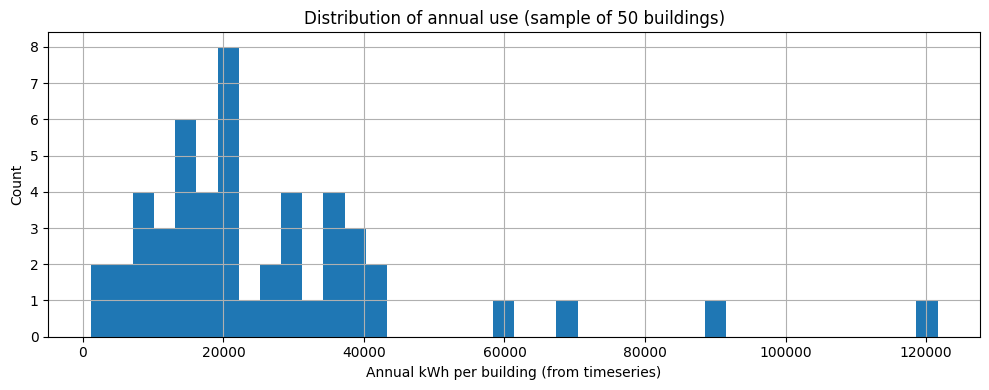

In [ ]:
# Annual kWh per building from timeseries
annual_kwh_ts = (
    ts_sample.groupby("bldg_id")["kwh_total"]
    .sum()
    .reset_index(name="annual_kwh_ts")
)

print("Annual kWh from timeseries (sample):")
display(annual_kwh_ts.describe())

# Histogram
plt.figure()
annual_kwh_ts["annual_kwh_ts"].hist(bins=40)
plt.xlabel("Annual kWh per building (from timeseries)")
plt.ylabel("Count")
plt.title(f"Distribution of annual use (sample of {n_use} buildings)")
plt.tight_layout()
plt.show()

In [5]:
if meta_sample is not None:
    meta_for_sample = meta_sample.merge(
        annual_kwh_ts, left_on="bldg_id", right_on="bldg_id", how="inner"
    )
    print("Joined metadata + annual kWh shape:", meta_for_sample.shape)

    # Some useful columns (only keep those that exist)
    candidate_cols = [
        "bldg_id",
        "in.county_name",
        "in.ahs_region",
        "in.representative_income",
        "in.building_type_recs",
        "in.tenure",
    ]
    existing_cols = [c for c in candidate_cols if c in meta_for_sample.columns]
    display(meta_for_sample[existing_cols].head())
else:
    meta_for_sample = None
    print("No metadata loaded; cannot join.")

Joined metadata + annual kWh shape: (50, 772)


,bldg_id,in.county_name,in.ahs_region,in.representative_income,in.tenure
0,10010,Essex County,"CBSA Boston-Cambridge-Newton, MA-NH",190819.0,Owner
1,10069,Middlesex County,"CBSA Boston-Cambridge-Newton, MA-NH",132034.0,Owner
2,10083,Hampshire County,Non-CBSA New England,73823.0,Owner
3,10180,Barnstable County,Non-CBSA New England,111397.0,Owner
4,100043,Worcester County,Non-CBSA New England,134088.0,Owner


In [7]:
if meta_for_sample is not None:
    for col in ["in.representative_income", "in.building_type_recs", "in.tenure"]:
        if col in meta_for_sample.columns:
            print(f"\n=== {col} ===")
            print(meta_for_sample[col].value_counts(dropna=False).head(20))
else:
    print("meta_for_sample is None; skipping feature coverage checks.")


=== in.representative_income ===
in.representative_income
NaN         3
38644.0     2
132034.0    1
111397.0    1
134088.0    1
26818.0     1
190819.0    1
292942.0    1
124248.0    1
322035.0    1
84579.0     1
128357.0    1
771751.0    1
56781.0     1
73823.0     1
129963.0    1
19804.0     1
21706.0     1
27660.0     1
116167.0    1
Name: count, dtype: int64

=== in.tenure ===
in.tenure
Owner            28
Renter           19
Not Available     3
Name: count, dtype: int64


In [8]:
if meta_for_sample is not None:
    geo_cols = [c for c in ["in.county_name", "in.ahs_region"] if c in meta_for_sample.columns]
    if geo_cols:
        print("County/region counts (top 20):")
        print(meta_for_sample[geo_cols].value_counts().head(20))
    else:
        print("No county/region columns detected in metadata.")
else:
    print("meta_for_sample is None; skipping geography checks.")

County/region counts (top 20):
in.county_name     in.ahs_region                      
Middlesex County   CBSA Boston-Cambridge-Newton, MA-NH    11
Worcester County   Non-CBSA New England                    7
Essex County       CBSA Boston-Cambridge-Newton, MA-NH     5
Norfolk County     CBSA Boston-Cambridge-Newton, MA-NH     5
Plymouth County    CBSA Boston-Cambridge-Newton, MA-NH     5
Hampshire County   Non-CBSA New England                    4
Suffolk County     CBSA Boston-Cambridge-Newton, MA-NH     4
Barnstable County  Non-CBSA New England                    2
Berkshire County   Non-CBSA New England                    2
Bristol County     Non-CBSA New England                    2
Hampden County     Non-CBSA New England                    2
Dukes County       Non-CBSA New England                    1
Name: count, dtype: int64


Example buildings: [101450, 100512, 100500]


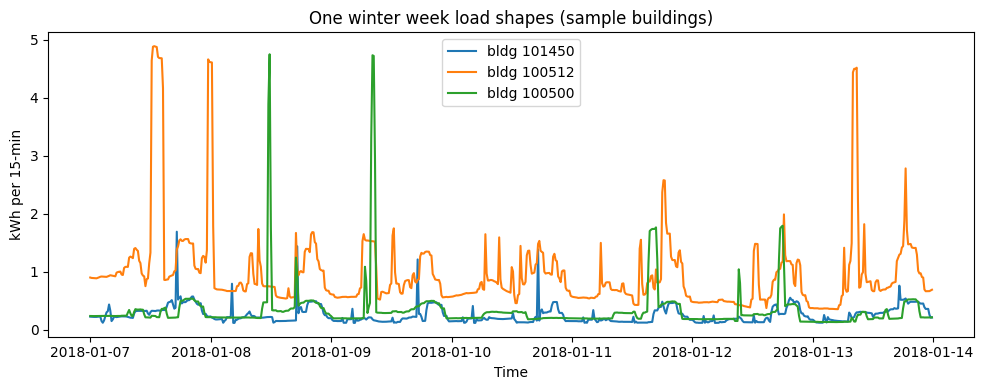

In [12]:
# Convert timestamp and choose 3 buildings
ts_sample["timestamp"] = pd.to_datetime(ts_sample["timestamp"])
bldg_ids_example = ts_sample["bldg_id"].drop_duplicates().sample(
    min(3, ts_sample["bldg_id"].nunique()),
    random_state=0,
).tolist()
print("Example buildings:", bldg_ids_example)

# One winter week
week_mask = (ts_sample["timestamp"] >= "2018-01-07") & (ts_sample["timestamp"] < "2018-01-14")
week_ts = ts_sample[week_mask & ts_sample["bldg_id"].isin(bldg_ids_example)]

plt.figure(figsize=(10, 4))
for b in bldg_ids_example:
    b_ts = week_ts[week_ts["bldg_id"] == b]
    plt.plot(b_ts["timestamp"], b_ts["kwh_total"], label=f"bldg {b}")

plt.xlabel("Time")
plt.ylabel("kWh per 15-min")
plt.title("One winter week load shapes (sample buildings)")
plt.legend()
plt.tight_layout()
plt.show()


## Tariff models and where to define them

For RQ1 we want to compare **multiple tariff structures** (e.g., flat, TOU, dynamic/RTP proxy)
on the **same set of household load profiles**.

We will structure this in two layers:

1. **Tariff pricing functions** (one per tariff)  
   Each takes timestamps (and optionally metadata) and returns a per-interval price in \$/kWh.  
   These can be simple (hard-coded flat rate) or complex (look up prices from an external
   dataset that teammates are familiar with).

2. **Generic bill calculator**  
   Given a timeseries DataFrame with `bldg_id`, `timestamp`, and `kwh_total`, plus a pricing
   function, compute:
   - `annual_kwh`
   - `annual_cost_<tariff_name>` per building

This design lets us swap in different pricing datasets or tariff logic **without changing the rest of the notebook**.

In [14]:
# === TARIFF PRICING HOOKS ===
# These functions turn timestamps (and optionally metadata) into a price (in $/kWh)
# for each 15-minute interval.


def price_flat(ts_df: pd.DataFrame,
               meta_df: pd.DataFrame | None = None,
               base_rate: float = 0.25) -> pd.Series:
    """
    Simple flat tariff: every kWh is charged at the same rate.

    Parameters
    ----------
    ts_df : DataFrame
        Must contain 'timestamp' and 'bldg_id' and 'kwh_total'.
    meta_df : DataFrame or None
        Not used in the simple version, but can be used if we ever want
        region- or customer-specific flat rates.
    base_rate : float
        Flat rate in $/kWh.

    Returns
    -------
    Series of length len(ts_df) with the price for each row (interval).
    """
    return pd.Series(base_rate, index=ts_df.index)


def price_tou_simple(ts_df: pd.DataFrame,
                     meta_df: pd.DataFrame | None = None,
                     offpeak_rate: float = 0.20,
                     peak_rate: float = 0.35,
                     peak_hours: tuple[int, int] = (16, 21)) -> pd.Series:
    """
    Simple Time-of-Use tariff example:
      - peak hours: from peak_hours[0] (inclusive) to peak_hours[1] (exclusive)
      - all other hours are off-peak.

    Assumes ts_df['timestamp'] is in local time (or close enough).

    Teammates could replace this with a more realistic TOU function that
    uses an external dataset or season/weekend distinctions.
    """
    hours = ts_df["timestamp"].dt.hour
    start, end = peak_hours
    is_peak = (hours >= start) & (hours < end)
    prices = np.where(is_peak, peak_rate, offpeak_rate)
    return pd.Series(prices, index=ts_df.index)


def price_dynamic_stub(ts_df: pd.DataFrame,
                       meta_df: pd.DataFrame | None = None) -> pd.Series:
    """
    Stub for a more complex 'dynamic' / RTP-like tariff.

    This is just a placeholder that currently behaves like a flat rate.
    Teammates can later implement this by:
      - loading a time-indexed price dataset (e.g. hourly RTP),
      - mapping each timestamp in ts_df to the appropriate price,
      - possibly conditioning on region (meta_df).

    For now, we just return a constant so the rest of the pipeline works.
    """
    # Example placeholder: 0.30 $/kWh constant
    return pd.Series(0.30, index=ts_df.index)

In [15]:
# === GENERIC BILL CALCULATION HELPERS ===


def apply_tariff(ts_df: pd.DataFrame,
                 price_func,
                 meta_df: pd.DataFrame | None = None,
                 tariff_name: str = "tariff") -> pd.DataFrame:
    """
    Apply a tariff pricing function to a load timeseries and compute annual bills.

    Parameters
    ----------
    ts_df : DataFrame
        Must contain at least:
          - 'bldg_id': building identifier
          - 'timestamp': datetime
          - 'kwh_total': total kWh in each 15-min interval
    price_func : callable
        Function with signature price_func(ts_df, meta_df=None, **kwargs)
        returning a Series of per-interval prices in $/kWh.
    meta_df : DataFrame or None
        Optional building-level metadata to pass into the pricing function.
        If used, meta_df should have a 'bldg_id' column.
    tariff_name : str
        Name of the tariff, used to label the 'annual_cost_<tariff_name>' column.

    Returns
    -------
    DataFrame with columns:
      - bldg_id
      - annual_kwh
      - annual_cost_<tariff_name>
    """
    df = ts_df.copy()

    # Compute price for each interval
    price_series = price_func(df, meta_df=meta_df)
    df[f"price_{tariff_name}"] = price_series

    # Cost per interval
    df[f"cost_{tariff_name}_interval"] = df["kwh_total"] * df[f"price_{tariff_name}"]

    # Aggregate to annual per building
    annual = (
        df.groupby("bldg_id")
        .agg(
            annual_kwh=("kwh_total", "sum"),
            **{f"annual_cost_{tariff_name}": (f"cost_{tariff_name}_interval", "sum")},
        )
        .reset_index()
    )

    return annual


def apply_all_tariffs(ts_df: pd.DataFrame,
                      meta_df: pd.DataFrame | None = None) -> pd.DataFrame:
    """
    Apply the set of tariffs we are studying (flat, TOU, dynamic stub)
    and return a single DataFrame with one row per building and
    one column per tariff's annual cost.

    This is the main object we will use for RQ1 analysis.
    """
    # Flat tariff
    flat = apply_tariff(ts_df, price_flat, meta_df=meta_df, tariff_name="flat")

    # TOU tariff (simple example for now)
    tou = apply_tariff(ts_df, price_tou_simple, meta_df=meta_df, tariff_name="tou")

    # Dynamic / RTP-like stub
    dyn = apply_tariff(ts_df, price_dynamic_stub, meta_df=meta_df, tariff_name="dynamic")

    # Merge on bldg_id
    merged = flat.merge(tou, on=["bldg_id", "annual_kwh"], how="inner")
    merged = merged.merge(dyn, on=["bldg_id", "annual_kwh"], how="inner")

    return merged


In [16]:
# Compute annual bills under all tariffs for the sample timeseries
bills_sample = apply_all_tariffs(ts_sample, meta_df=meta_sample)
print("bills_sample shape:", bills_sample.shape)
display(bills_sample.head())

# Join with metadata to get fairness-relevant attributes
if meta_sample is not None:
    bills_with_meta = meta_sample.merge(bills_sample, on="bldg_id", how="inner")
    print("bills_with_meta shape:", bills_with_meta.shape)
else:
    bills_with_meta = None
    print("No metadata available; cannot attach attributes.")


bills_sample shape: (50, 5)


,bldg_id,annual_kwh,annual_cost_flat,annual_cost_tou,annual_cost_dynamic
0,10010,59763.164062,14940.791371,14645.122280,17928.949645
1,10069,16166.855469,4041.713769,3890.401936,4850.056522
2,10083,15136.975586,3784.243808,3627.105599,4541.092570
3,10180,16988.794922,4247.198566,4172.511143,5096.638279
4,100043,37892.546875,9473.136318,9392.471760,11367.763582


bills_with_meta shape: (50, 775)


## Visualizing RQ1: how do tariffs affect bills and who pays more?

We now have, for each building in our sample:

- annual electricity use (`annual_kwh`)
- annual bill under:
  - flat tariff
  - simple TOU tariff
  - dynamic/RTP-like stub

We want to:
1. Compare the **overall distribution** of annual bills under each tariff.  
2. Explore how bills vary across **income levels** (and other attributes) under each tariff.  
3. Look at **differences between tariffs** (e.g. TOU vs flat) and who gains/loses.

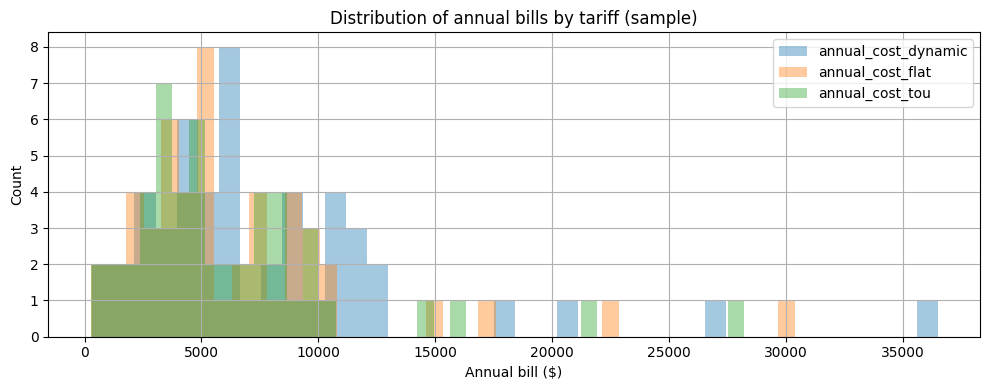

In [17]:
if bills_with_meta is not None:
    # Melt to long format for easier plotting
    bill_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]
    bills_long = bills_with_meta.melt(
        id_vars=["bldg_id", "annual_kwh"],
        value_vars=bill_cols,
        var_name="tariff",
        value_name="annual_cost",
    )

    # Simple histogram per tariff (overlayed)
    plt.figure(figsize=(10, 4))
    for name, grp in bills_long.groupby("tariff"):
        grp["annual_cost"].hist(bins=40, alpha=0.4, label=name)
    plt.xlabel("Annual bill ($)")
    plt.ylabel("Count")
    plt.title("Distribution of annual bills by tariff (sample)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("bills_with_meta is None; cannot plot bill distributions.")

<Figure size 600x400 with 0 Axes>

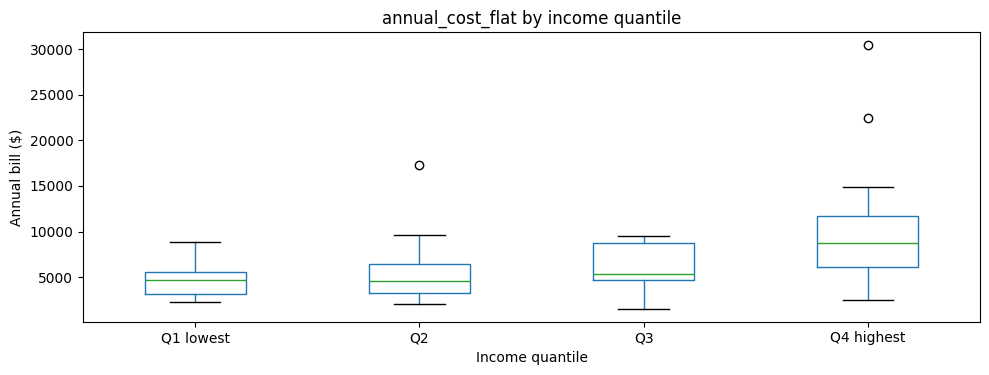

<Figure size 600x400 with 0 Axes>

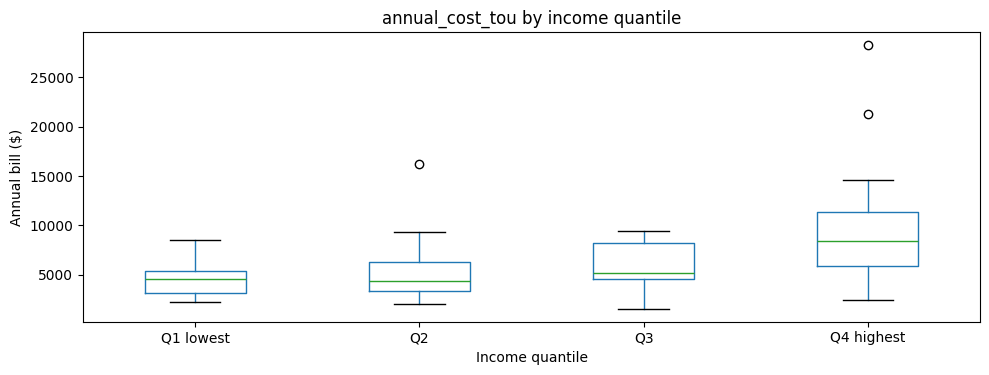

<Figure size 600x400 with 0 Axes>

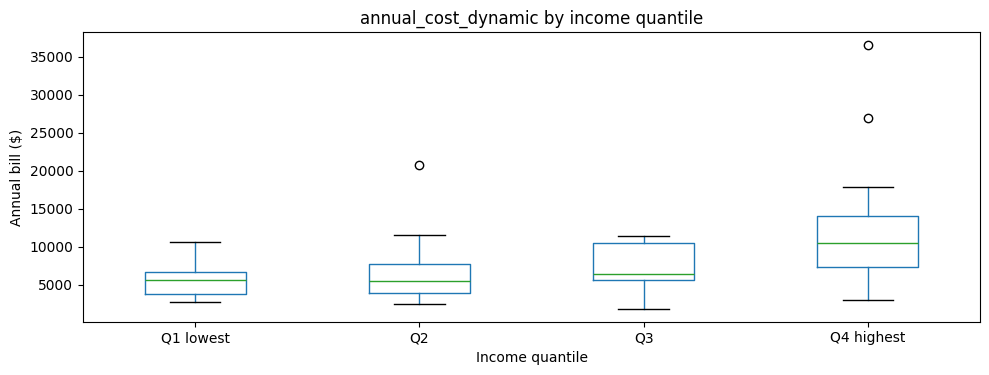

Summary of annual bills by income quantile:


C:\Users\Manny\AppData\Local\Temp\ipykernel_48720\3801112412.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bills_with_meta.groupby("income_quantile")[bill_cols]


,annual_cost_flat_mean,annual_cost_flat_std,annual_cost_flat_min,annual_cost_flat_max,annual_cost_tou_mean,annual_cost_tou_std,annual_cost_tou_min,annual_cost_tou_max,annual_cost_dynamic_mean,annual_cost_dynamic_std,annual_cost_dynamic_min,annual_cost_dynamic_max
income_quantile,,,,,,,,,,,,
Q1 lowest,4814.552622,2014.045050,2262.378049,8808.590780,4723.971855,1943.846862,2190.256267,8545.140319,5777.463147,2416.854060,2714.853658,10570.308936
Q2,5815.564348,4260.565809,2028.333728,17319.066032,5613.474652,3962.943228,1993.006559,16201.504108,6978.677218,5112.678971,2434.000473,20782.879238
Q3,6236.282772,2550.275174,1551.180463,9473.136318,6045.581838,2443.391708,1570.733329,9392.471760,7483.539327,3060.330209,1861.416556,11367.763582
Q4 highest,10869.670015,8237.353083,2484.279728,30413.090963,10365.584583,7668.215803,2463.951803,28228.272236,13043.604018,9884.823699,2981.135673,36495.709155


In [19]:
if bills_with_meta is not None and "in.representative_income" in bills_with_meta.columns:
    # Define income quartiles
    bills_with_meta["income_quantile"] = pd.qcut(
        bills_with_meta["in.representative_income"],
        q=4,
        labels=["Q1 lowest", "Q2", "Q3", "Q4 highest"],
    )

    # Boxplots: annual bill by income quantile for each tariff
    for col in ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]:
        plt.figure(figsize=(6, 4))
        bills_with_meta.boxplot(
            column=col,
            by="income_quantile",
            grid=False,
        )
        plt.title(f"{col} by income quantile")
        plt.suptitle("")  # remove default pandas title
        plt.xlabel("Income quantile")
        plt.ylabel("Annual bill ($)")
        plt.tight_layout()
        plt.show()

    # Ensure bill_cols is defined in this cell
    bill_cols = ["annual_cost_flat", "annual_cost_tou", "annual_cost_dynamic"]

    # Numeric summary using agg (no MultiIndex headache from describe)
    summary = (
        bills_with_meta.groupby("income_quantile")[bill_cols]
        .agg(["mean", "std", "min", "max"])
    )

    # Optionally flatten the MultiIndex columns for easier reading
    summary.columns = [
        f"{tariff}_{stat}" for tariff, stat in summary.columns
    ]

    print("Summary of annual bills by income quantile:")
    display(summary)
else:
    print("Income field missing or bills_with_meta is None; skipping income-based plots.")


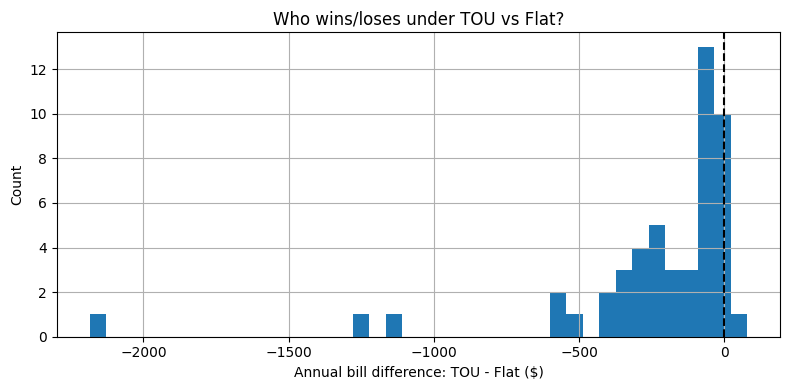

<Figure size 600x400 with 0 Axes>

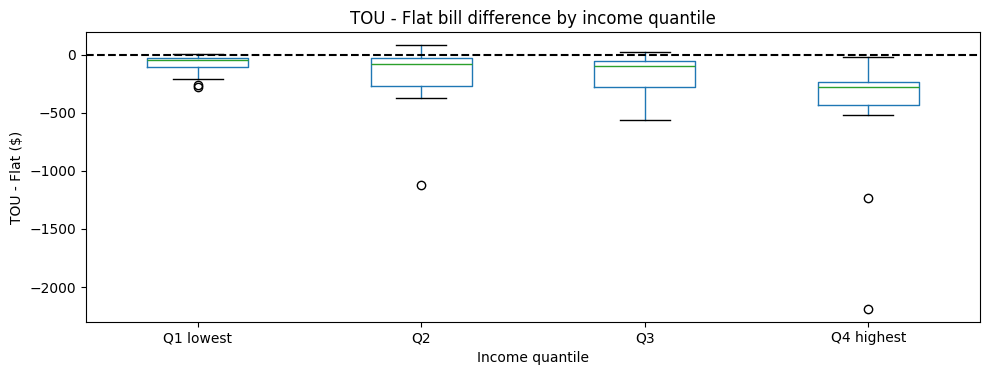

In [20]:
if bills_with_meta is not None:
    bills_with_meta["delta_tou_minus_flat"] = (
        bills_with_meta["annual_cost_tou"] - bills_with_meta["annual_cost_flat"]
    )
    bills_with_meta["delta_dynamic_minus_flat"] = (
        bills_with_meta["annual_cost_dynamic"] - bills_with_meta["annual_cost_flat"]
    )

    # Histogram of the difference TOU - flat
    plt.figure(figsize=(8, 4))
    bills_with_meta["delta_tou_minus_flat"].hist(bins=40)
    plt.axvline(0, color="k", linestyle="--")
    plt.xlabel("Annual bill difference: TOU - Flat ($)")
    plt.ylabel("Count")
    plt.title("Who wins/loses under TOU vs Flat?")
    plt.tight_layout()
    plt.show()

    # Optional: difference by income quantile
    if "income_quantile" in bills_with_meta.columns:
        plt.figure(figsize=(6, 4))
        bills_with_meta.boxplot(
            column="delta_tou_minus_flat",
            by="income_quantile",
            grid=False,
        )
        plt.axhline(0, color="k", linestyle="--")
        plt.title("TOU - Flat bill difference by income quantile")
        plt.suptitle("")
        plt.xlabel("Income quantile")
        plt.ylabel("TOU - Flat ($)")
        plt.tight_layout()
        plt.show()
else:
    print("bills_with_meta is None; cannot compute tariff differences.")
